<a href="https://colab.research.google.com/github/tvtp11052002/Phong/blob/main/BTtoan_13_5_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats, interpolate
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 18})

Z-test: So sánh mean của mẫu với mean của tổng thể. Điều kiện sử dụng Z-test:
- Phương sai σ đã biết và cỡ mẫu N tùy ý.
- Phương sai chưa biết và N≥30.
- Nếu N<30 thì cần kiểm tra dữ liệu là phân phối chuẩn.
Kiểm định 2 phía:
H0: μ=μ0.
H1: μ≠μ0.
Với mức ý nghĩa α (significant level), ta cần tìm t∗ sao cho P(|X|>t∗)=α. Giá trị t∗ được gọi là giá trị tới hạn (critical value).
Cách tính t∗: Ta có P(|X|≤t∗)=1−α. Do tính đối xứng, ta có P(0≤X≤t∗)=P(−t∗≤X≤0)=(1−α)/2. Điều này tương đương với ϕ(t∗)=(1−α)/2.
Ví dụ: Với α=0.05 thì (1−α)/2=0.475. Ta cần giải phương trình ϕ(t∗)=0.475. Từ bảng A2 ta có t∗=ϕ^−1(0.475)=1.96.
Ví dụ: Với α=0.01 thì (1−α)/2=0.495. Ta cần giải phương trình ϕ(t∗)=0.475. Từ bảng A2 ta có t∗=ϕ^−1(0.495)=2.57.
Miền bác bỏ: 
Bα=(−∞,−t∗)∪(t∗,+∞)
Gọi Ktn (statistical score) là giá trị thống kê thực nghiệm được tính ra từ mẫu. Ta có giá trị p (p value) được tính bởi: p=P(|X|>Ktn).
Kết luận:
Nếu Ktn∈B thì bác bỏ giả thiết H0. Điều này tương đương với p<α
.Kiểm định 1 phía:
H0: μ=μ0.
H1: μ>μ0. (H1: μ<μ0).
Tính giá trị tới hạn bằng Python:

In [ ]:
# Tính giá trị tới hạn bằng scipy và hàm ppf (hàm ngược của hàm cdf) #
from scipy.stats import norm
def critical_value(alpha, tail=0):
    '''Tính giá trị tới hạn: tail=0:: 2phia; tail=-1:left; tail=1:right'''
    if tail == -1: 
        return norm.ppf(alpha)
    elif tail == 1: 
        return norm.ppf(1-alpha)
    else: 
        return (norm.ppf(alpha/2), norm.ppf(1- alpha/2))

alpha = 0.05
                
# tu bang A.2 chon t_* = 1.96
# dung ham cdf de tinh gia tri p chinh xac neu t_*=1.96
print(f"Giá trị tới hạn 2 phía: {critical_value(alpha)}")
print(f"Giá trị tới hạn 1 phía (trái): {critical_value(alpha, tail=-1)}")
print(f"Giá trị tới hạn 1 phía (phải): {critical_value(alpha, tail=1)}")
# Khi thi ta chấp nhận t_* = 1.96
# Trong khi thực hành thì ta không chấp nhận t_*=1.96 mà giá trị thực là t_* = 1.95996

Giá trị tới hạn 2 phía: (-1.9599639845400545, 1.959963984540054)
Giá trị tới hạn 1 phía (trái): -1.6448536269514729
Giá trị tới hạn 1 phía (phải): 1.6448536269514722


Thực hành: Viết hàm tính giá trị tới hạn 1 phía: μ>μ0 và μ<μ0.

In [ ]:
gia_nha_dat_us = pd.read_csv("C:\\Users\\DUC-PC\\Downloads\\gia_nha_dat_us.csv")
gia_nha_dat_us.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df = gia_nha_dat_us[['MSSubClass', 'MSZoning', 'LotArea', 'SalePrice']]
df.head()

,MSSubClass,MSZoning,LotArea,SalePrice
0,60,RL,8450,208500
1,20,RL,9600,181500
2,60,RL,11250,223500
3,70,RL,9550,140000
4,60,RL,14260,250000


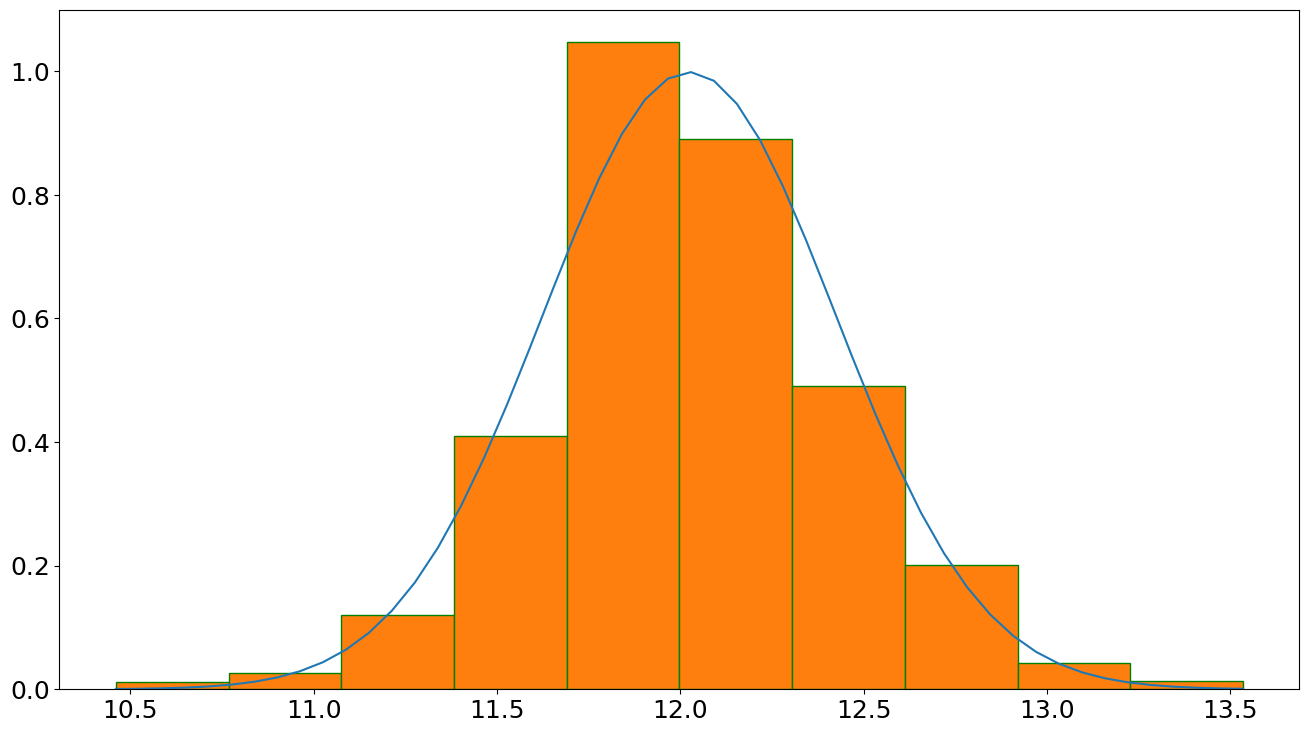

In [ ]:
# Engineering feature: log transform #
data = df['SalePrice']
# Sử dụng ln(1+r) ~ r để tránh rate of change #
data = np.log1p(data)

# Kiem tra data co chuan hay khong?
mean = np.mean(data)
# ddof=1 :: hiệu chỉnh
std = np.std(data, ddof=1)
domain = np.linspace(np.min(data), np.max(data))
plt.plot(domain, stats.norm.pdf(domain, mean, std))
#density=True :: chuẩn hóa dữ liệu về normal
plt.hist(data, edgecolor='green', density=True)
plt.show()

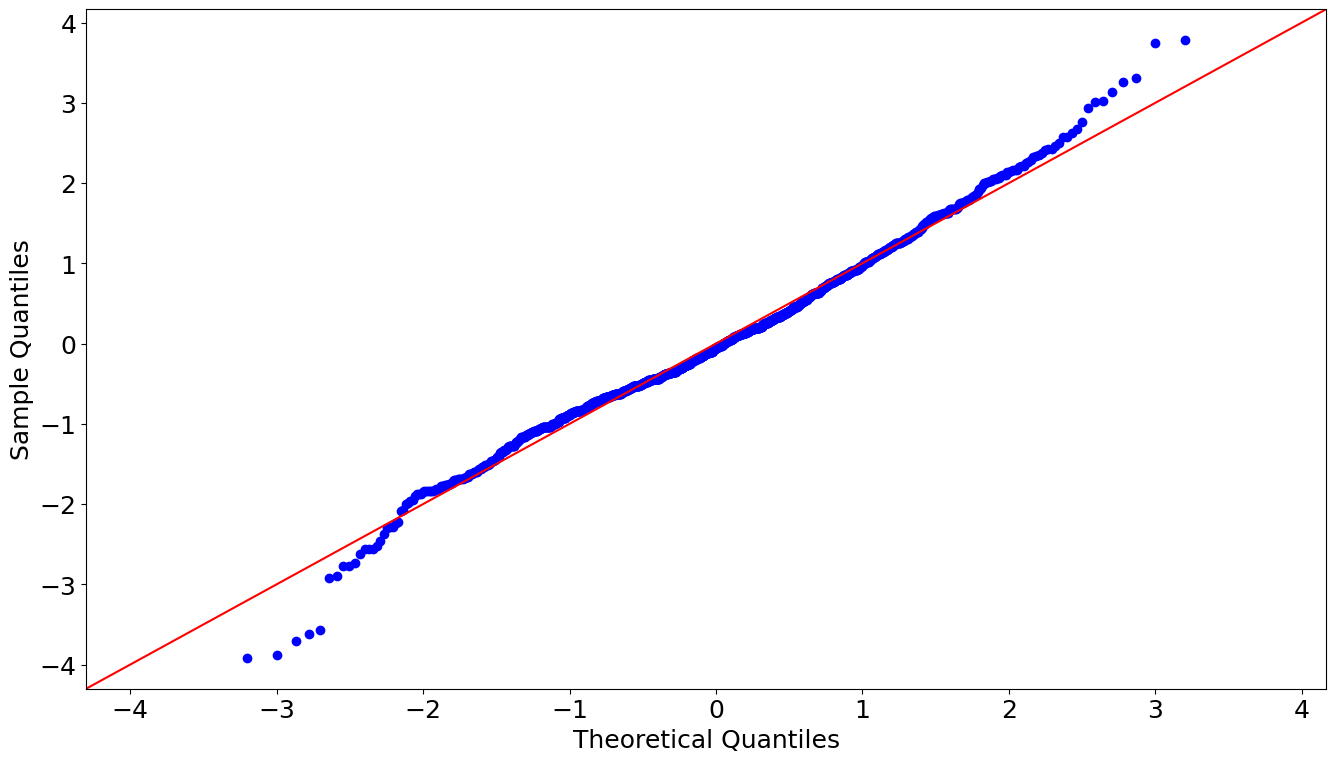

In [ ]:
import statsmodels.api as sm
# Đưa dữ liệu về dạng chuẩn tắc #
def standadize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean)/std

sm.qqplot(standadize(data), line ='45')
plt.show()


Bài toán: Có người cho rằng giá nhà trung bình ở Mỹ là $150k, khẳng định trên có đúng không về mặt thống kê với mức ý nghĩa là 5%?

(Bài toán so sánh giá trị trung bình của mẫu với trung bình kỳ vọng lý thuyết μ0).

In [ ]:
my_mean = 150000
my_log_mean = np.log1p(my_mean)
print(my_log_mean)

11.918397239722838


In [ ]:
def results(p, vals=['mean1', 'mean2'], alpha=0.05):
    cols=['score', 'p_value', 'KetLuan']
    if p['p_value'] < alpha:
        p['KetLuan'] = f"Chấp nhận H1 với mức ý nghĩa {alpha}"
    if p['p_value'] >= alpha:
        p['KetLuan'] = f"Chấp nhận H0 với mức ý nghĩa {alpha}"
    df = pd.DataFrame(p, index=[''])
    if vals: cols = vals + cols
    return df[cols]

In [ ]:
# Lay ngau nhien 100 diem du lieu #
sample = data.sample(n=100)

In [ ]:
#Kiem dinh mean cua sample so voi ky vong mu_0=11.918397239722838
# kiem dinh 2 phia: H0: mu = mu_0, H1: mu != mu_0
from scipy.stats import ttest_1samp
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.084473,11.918397,4.026487,0.000111,Chấp nhận H1 với mức ý nghĩa 0.05


Kiểm định 1 phía

In [ ]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben trai: H0 mu = mu_0, H1: mu < mu_0
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='less')
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.084473,11.918397,4.026487,0.999944,Chấp nhận H0 với mức ý nghĩa 0.05


In [ ]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben trai: H0 mu = mu_0, H1: mu < mu_0
import statsmodels.stats
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='greater')
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.084473,11.918397,4.026487,0.000056,Chấp nhận H1 với mức ý nghĩa 0.05


Bài tập về nhà:

a) Hãy chọn giá trị n lớn hơn 100 khác nhau và chạy các thống kê ở trên để đưa ra kết luận.

b) Hãy thay đổi my_mean khác nhau để tìm ra được giá trị kỳ vọng gần với giá trị trung bình của mẫu (với mức ý nghĩa 0.05).

 

In [ ]:
def kiemdinh2phia(sample, my_log_mean):
    print("Kiểm định 2 phía")
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
    return results(p)

def kiemdinh_bentrai(sample, my_log_mean):
    print("Kiểm định 1 phía về bên trái")
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='less')
    return results(p)
    
def kiemdinh_benphai(sample, my_log_mean):
    print("Kiểm định 1 phía về bên phải")
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='greater')
    return results(p)

def hist_plot(data):
    mu = np.mean(data)
    sigma = np.std(data)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red')
    plt.hist(data, density=True, color = 'pink', edgecolor = 'red')
    plt.title(data.name)
    plt.show()

def qq_plot(data):
    sm.qqplot(data, line ='45', color = 'cyan')
    plt.show()


Kiểm định 2 phía
      mean1      mean2   score   p_value                            KetLuan
  12.065245  11.918397  4.6458  0.000007  Chấp nhận H1 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên trái
      mean1      mean2   score   p_value                            KetLuan
  12.065245  11.918397  4.6458  0.999997  Chấp nhận H0 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên phải
      mean1      mean2   score   p_value                            KetLuan
  12.065245  11.918397  4.6458  0.000003  Chấp nhận H1 với mức ý nghĩa 0.05


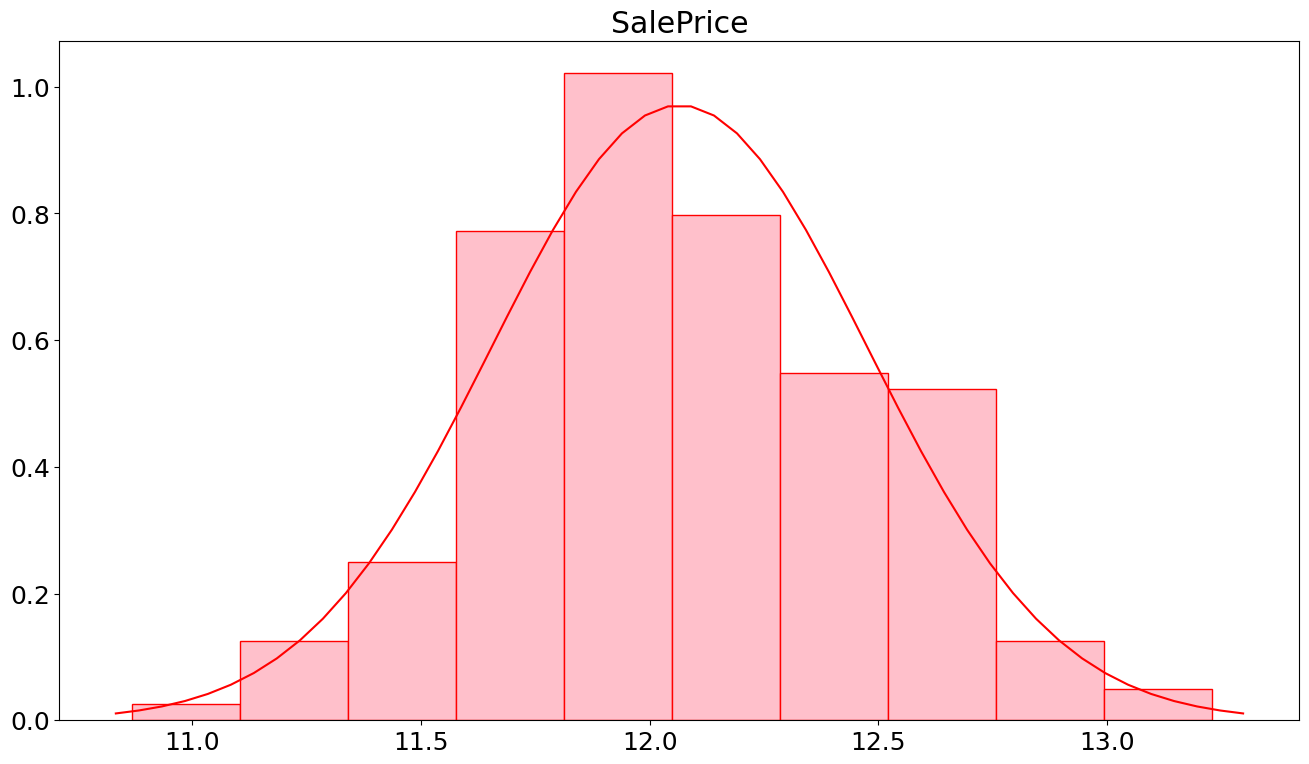

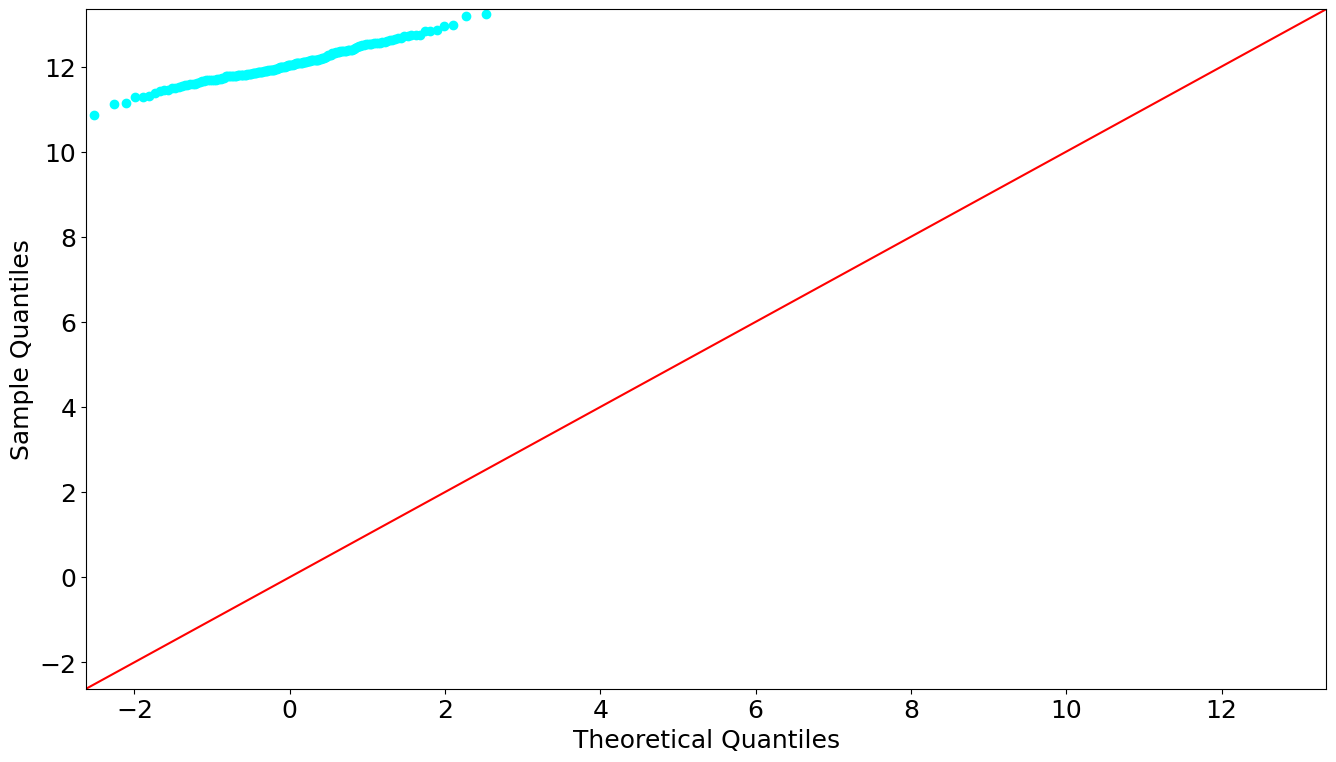

------------------------------------------------------------
Kiểm định 2 phía
      mean1      mean2     score   p_value                            KetLuan
  12.008373  11.918397  2.858097  0.004873  Chấp nhận H1 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên trái
      mean1      mean2     score   p_value                            KetLuan
  12.008373  11.918397  2.858097  0.997564  Chấp nhận H0 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên phải
      mean1      mean2     score   p_value                            KetLuan
  12.008373  11.918397  2.858097  0.002436  Chấp nhận H1 với mức ý nghĩa 0.05


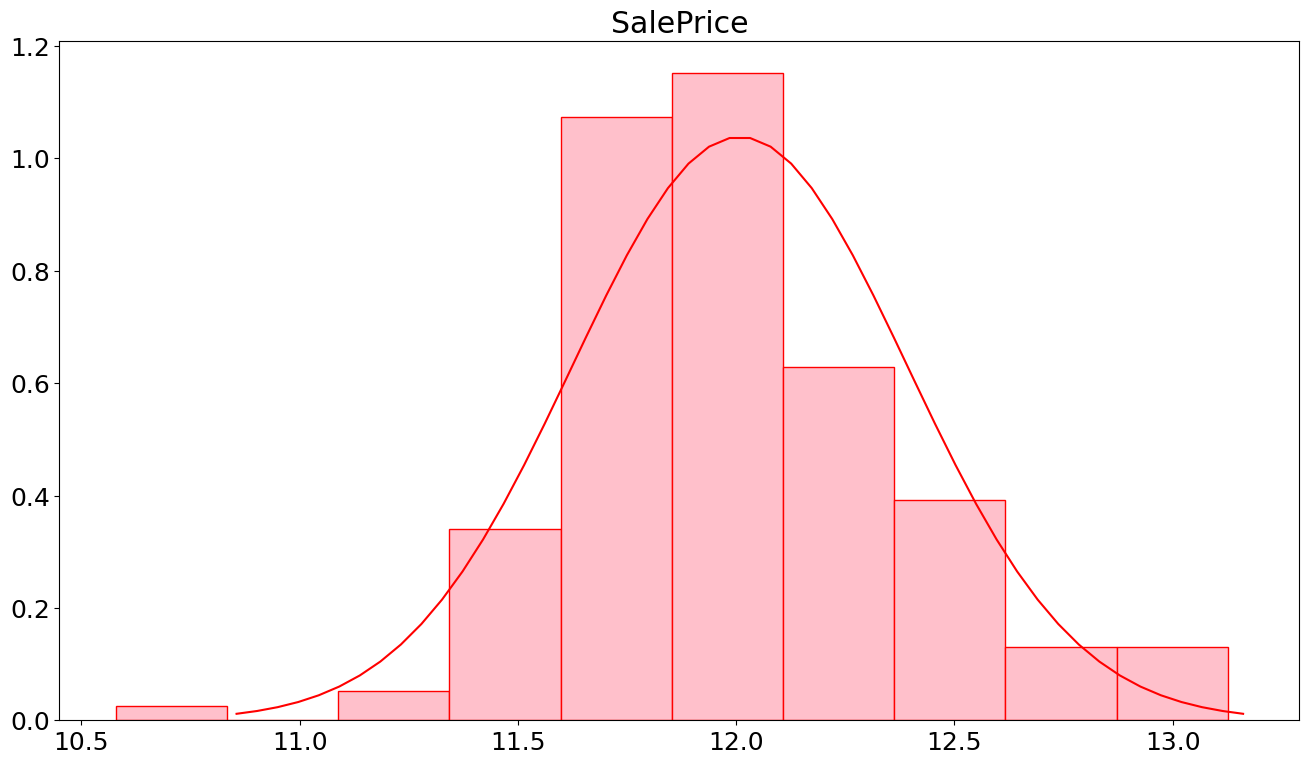

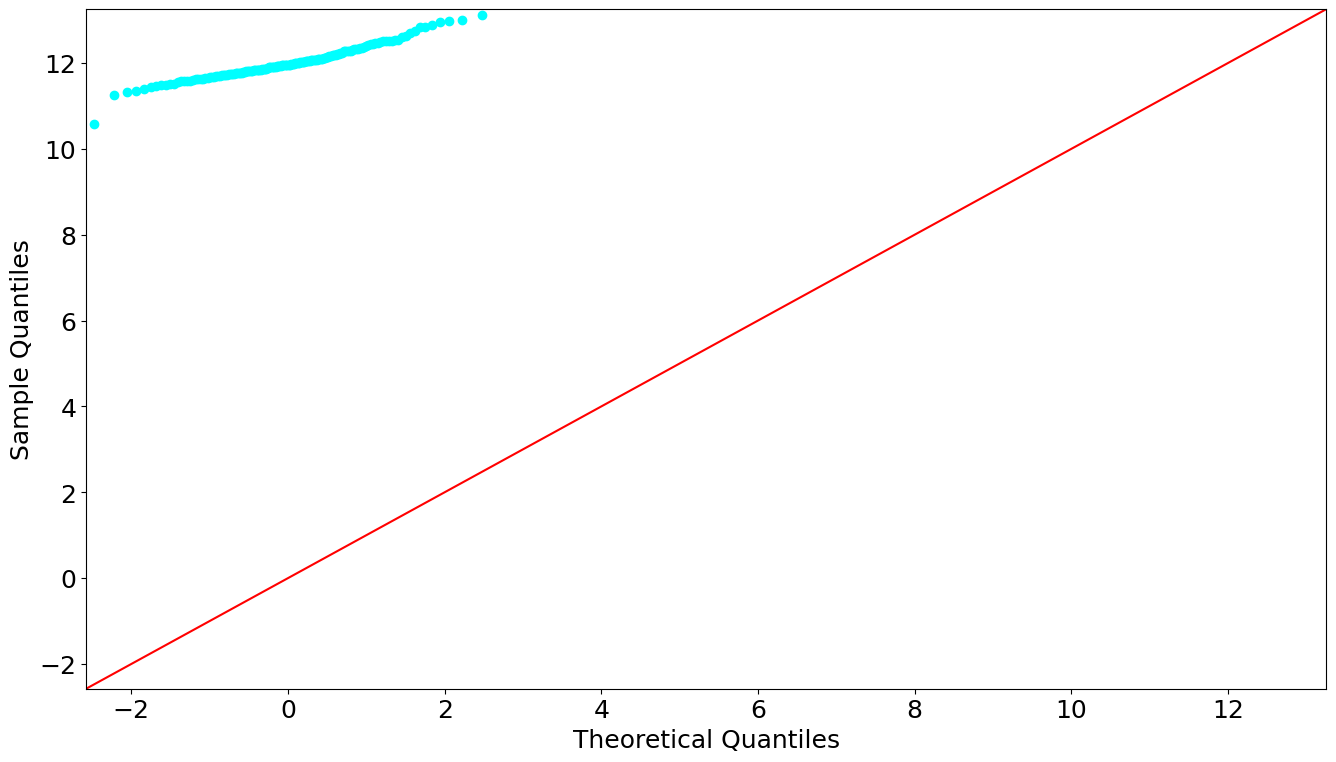

------------------------------------------------------------
Kiểm định 2 phía
      mean1      mean2    score   p_value                            KetLuan
  12.056886  11.918397  4.00261  0.000109  Chấp nhận H1 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên trái
      mean1      mean2    score   p_value                            KetLuan
  12.056886  11.918397  4.00261  0.999945  Chấp nhận H0 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên phải
      mean1      mean2    score   p_value                            KetLuan
  12.056886  11.918397  4.00261  0.000055  Chấp nhận H1 với mức ý nghĩa 0.05


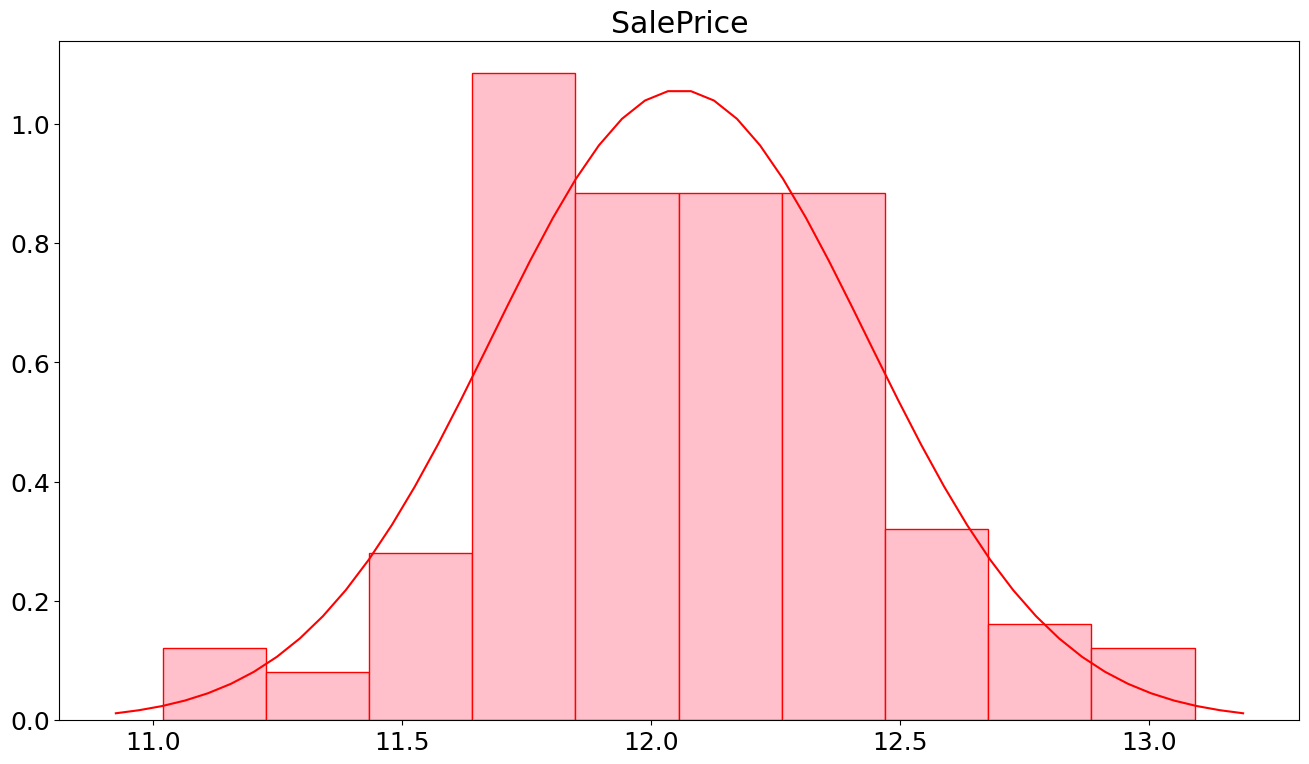

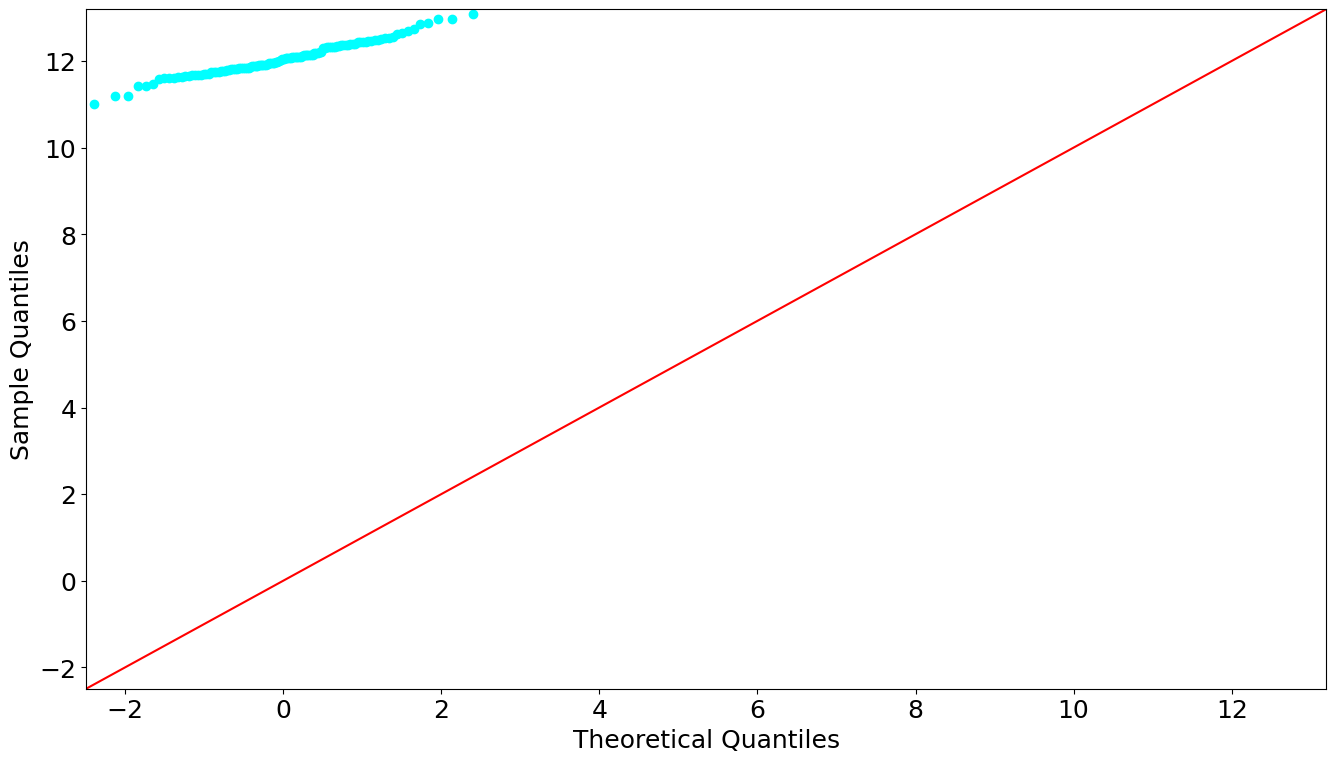

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
#a.Hãy chọn giá trị n lớn hơn 100 khác nhau và chạy các thống kê ở trên để đưa ra kết luận.
sample1 = data.sample(n=170)
sample2 = data.sample(n=150)
sample3 = data.sample(n=120)
print(kiemdinh2phia(sample1, my_log_mean))
print(kiemdinh_bentrai(sample1, my_log_mean))
print(kiemdinh_benphai(sample1, my_log_mean))
hist_plot(sample1)
qq_plot(sample1)
print("--"*30)
print(kiemdinh2phia(sample2, my_log_mean))
print(kiemdinh_bentrai(sample2, my_log_mean))
print(kiemdinh_benphai(sample2, my_log_mean))
hist_plot(sample2)
qq_plot(sample2)
print("--"*30)
print(kiemdinh2phia(sample3, my_log_mean))
print(kiemdinh_bentrai(sample3, my_log_mean))
print(kiemdinh_benphai(sample3, my_log_mean))
hist_plot(sample3)
qq_plot(sample3)
print("~~"*30)

In [ ]:
#b.Hãy thay đổi my_mean khác nhau để tìm ra được giá trị kỳ vọng gần với giá trị trung bình của mẫu (với mức ý nghĩa 0.05).
my_mean1 = 150000
print(np.log1p(my_mean1))
my_mean2=160000
print(np.log1p(my_mean2))
my_mean3 = 175000
print(np.log1p(my_mean3))
#Chọn np.log1p(my_mean3)
my_log_mean3 = np.log1p(my_mean3)
print(kiemdinh2phia(sample, my_log_mean3))
print(kiemdinh_bentrai(sample, my_log_mean3))
print(kiemdinh_benphai(sample, my_log_mean3))

11.918397239722838
11.982935344196433
12.07254696717504
Kiểm định 2 phía
      mean1      mean2    score   p_value                            KetLuan
  12.084473  12.072547  0.28914  0.773079  Chấp nhận H0 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên trái
      mean1      mean2    score  p_value                            KetLuan
  12.084473  12.072547  0.28914  0.61346  Chấp nhận H0 với mức ý nghĩa 0.05
Kiểm định 1 phía về bên phải
      mean1      mean2    score  p_value                            KetLuan
  12.084473  12.072547  0.28914  0.38654  Chấp nhận H0 với mức ý nghĩa 0.05
